# Analyzing outliers from data & Returning Dates

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import numpy as np
import os
import time
from itertools import chain
from IPython.display import display_html


##### ETF Data Clean up ###########

class ETFDataCleanup(object):
    
    def __init__(self):
        pass

    def showNaColumns(self,df):
        s=df.isnull().sum()
        print(s[s>0])
    
    def dropNAColumns(self,df):
        return df.dropna(axis='columns')
    
    def computeDailyReturns(self,df):
        return df.pct_change().dropna()        
    
    
####### Get Data for Constituents of ETF

class ConstituentsData(ETFDataCleanup):
    
    def __init__(self,fileName=None,startdate=None,enddate=None):
        self.fileName=fileName
        self.startdate=startdate
        self.enddate=enddate
        self.constituentdata=[]
        self.constituentcloseDF=[]
        self.tickerdf=[]
        self.changeDF=[]
        self.waDF=[]
    
    def getconstituentdata(self):
        self.tickerdf = pd.read_excel(self.fileName)
        tickers=self.tickerdf['Ticker']
        self.tickerdf.set_index('Ticker',inplace=True)
        self.constituentdata =  web.DataReader(tickers,'yahoo',self.startdate,self.enddate)
        self.constituentcloseDF = self.constituentdata['Close'].iloc[:, :]
        
    def stringWeightsToFloat(self):
        self.tickerdf['Weights']=self.tickerdf['Weights'].apply(lambda x: x.replace('%','')).astype(float)
    
    def findNetAssetValue(self):
        self.waDF=self.changeDF.copy()
        for col in self.changeDF.columns:
            # Divide by 100 for weights percentage eg 23.28%
            self.waDF[col]=self.changeDF[col]*self.tickerdf['Weights'].loc[col]/100
        self.waDF['NAV']=self.waDF.sum(axis=1)

####### Get prices of ETF        
class ETFStockPrices(ETFDataCleanup):
    
    def __init__(self,etfticker=None,startdate=None,enddate=None):
        self.etfticker=etfticker
        self.startdate=startdate
        self.enddate=enddate
        self.etfdata=[]
        self.etfchangeDF=[]

        
    def getETFTickerData(self):
        self.etfdata =  web.DataReader(self.etfticker,'yahoo',self.startdate,self.enddate)
 


class ETFArbitrage(object):

    def __init__(self,etfob,waDF):
        self.navDF=pd.merge(etfob,waDF['NAV'],left_index=True,right_index=True)
        self.navDF['Date']=self.navDF.index
        self.navDF['Close']=self.navDF['Close']*100
        self.navDF['NAV']=self.navDF['NAV']*100
        del self.navDF['Date']
        self.navDF['Mispricing']=(self.navDF['Close']-self.navDF['NAV'])
        self.navDF['Z-Score'] = np.abs(stats.zscore(self.navDF['Mispricing']))
    
    def scatterplot(self):
        plt.scatter(self.navDF['Close'],self.navDF['NAV'])
        
    def scatterplot2(self):
        #change figure size for the plot
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0]=12
        fig_size[1]=6
        plt.rcParams["figure.figsize"]=fig_size

        plt.scatter(self.navDF.index,self.navDF['Mispricing'])
    
    def seaborndist(self):
        sns.distplot(self.navDF['Mispricing'].values, hist=True, kde=True, 
             bins='auto', color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
        


# Load any ETF you want

XLK
Tickers with NA Values
Symbols
NLOK    65
dtype: int64
***************
Check for NA Values again
Series([], dtype: int64)
Symbols         AAPL      MSFT         V      INTC        MA      CSCO  \
Date                                                                     
2020-01-16  0.012526  0.018323  0.005756  0.012216  0.019252  0.021662   
2020-01-17  0.011071  0.005597  0.018661 -0.001006  0.010490 -0.000612   
2020-01-21 -0.006777 -0.003591  0.012653  0.015940 -0.005345 -0.004488   
2020-01-22  0.003570 -0.004805  0.002943  0.036003  0.007393  0.005533   
2020-01-23  0.004816  0.006156 -0.006638  0.009405  0.002066 -0.001427   
2020-01-24 -0.002882 -0.010077 -0.007360  0.081333 -0.004031 -0.003061   
2020-01-27 -0.029405 -0.016723 -0.016146 -0.040602 -0.024408 -0.028250   
2020-01-28  0.028289  0.019596  0.005751  0.024661  0.014251  0.006320   
2020-01-29  0.020932  0.015593  0.009909 -0.014559  0.000156 -0.015072   
2020-01-30 -0.001449  0.028208  0.016353  0.002111  0.012925

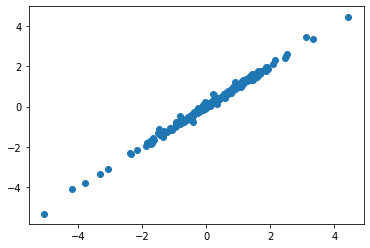

/home/piyush/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


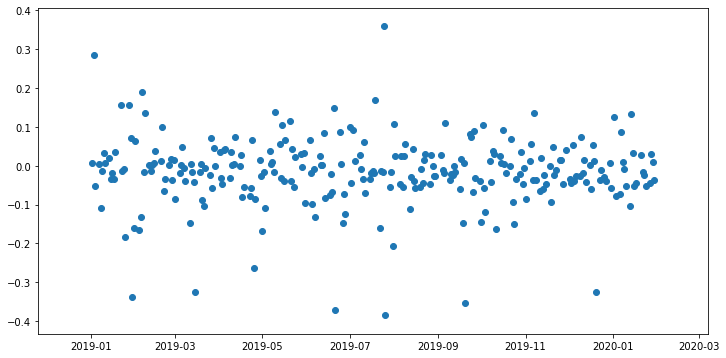

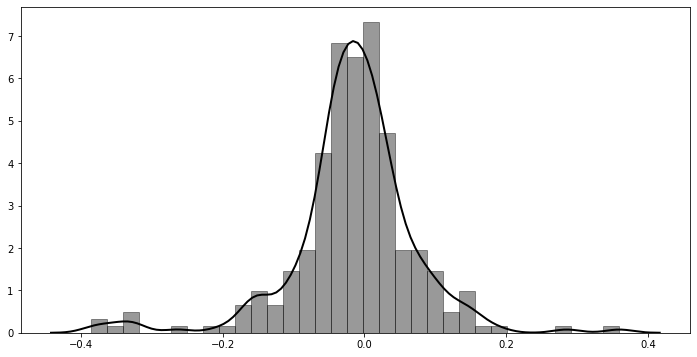

In [2]:
tickeretf="XLK"

filename='ETFDailyData'+'/'+dt.datetime.now().strftime("%Y%m%d")+'/'+tickeretf+'.xls'
startdate=dt.datetime(2019,1,1)
enddate=dt.datetime.today()

ob=ConstituentsData(fileName=filename,startdate=startdate,enddate=enddate)
ob.getconstituentdata()
print(tickeretf)
print("Tickers with NA Values")
ob.showNaColumns(ob.constituentcloseDF)
ob.constituentcloseDF=ob.dropNAColumns(ob.constituentcloseDF)
print("***************")
print("Check for NA Values again")
ob.showNaColumns(ob.constituentcloseDF)
ob.changeDF=ob.computeDailyReturns(ob.constituentcloseDF)
print(ob.changeDF.tail(10))


ob.stringWeightsToFloat()
ob.findNetAssetValue()

print("***************")
print("Data for Constituents")
print(ob.waDF.head(5))

etfob=ETFStockPrices(etfticker=tickeretf,startdate=startdate,enddate=enddate)
etfob.getETFTickerData()
print("Show Any Empty Values")
etfob.showNaColumns(etfob.etfdata)
etfob.etfchangeDF=etfob.computeDailyReturns(etfob.etfdata['Close'])


print("***************")
print("Data for ETF stock prices")
print(etfob.etfchangeDF.head(5))

print("****************")
print("Charts")
arbob=ETFArbitrage(etfob.etfchangeDF,ob.waDF)
arbob.scatterplot()
plt.show()
arbob.scatterplot2()
plt.show()
arbob.seaborndist()
plt.show()



# List down all objects of 3 different classes

In [3]:
print("Constituents Data Objects")
print(dir(ob))

print("*************************")
print("ETF Price Object")
print(dir(etfob))

print("*************************")
print("Arbitrage Data Object")
print(dir(arbob))

Constituents Data Objects
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'changeDF', 'computeDailyReturns', 'constituentcloseDF', 'constituentdata', 'dropNAColumns', 'enddate', 'fileName', 'findNetAssetValue', 'getconstituentdata', 'showNaColumns', 'startdate', 'stringWeightsToFloat', 'tickerdf', 'waDF']
*************************
ETF Price Object
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compute

## arbob.navDF is the ETF arbitrage dataframe which tells about 
1) Daily Return of ETF<br>
2) NET Asset Value of ETF<br>
3) Mispricing <br>
4) Stocks which moved XLK ETF the most<br>

In [4]:
print(arbob.navDF.head(5))

               Close       NAV  Mispricing   Z-Score
Date                                                
2019-01-02  0.064538  0.056540    0.007999  0.266017
2019-01-03 -5.046761 -5.332298    0.285538  3.411760
2019-01-04  4.431993  4.483521   -0.051528  0.408686
2019-01-07  0.894308  0.888819    0.005489  0.237571
2019-01-08  0.838035  0.947695   -0.109661  1.067586


## Z-Score Method

In [5]:
tempChangeDf=ob.changeDF.copy()*100
tempChangeDf=round(tempChangeDf,4)

In [6]:
negmovers=[]
posmovers=[]

for col in tempChangeDf.T:
    values=(tempChangeDf.T[col].sort_values())
    negmovers.append(dict(values[:3]))
    posmovers.append(dict(values[(len(values)-3):]))

    
arbob.navDF['Top negmovers']=negmovers
arbob.navDF['Top posmovers']=posmovers    

In [7]:
arbob.navDF

,Close,NAV,Mispricing,Z-Score,Top negmovers,Top posmovers
Date,,,,,,
2019-01-02,0.064538,0.056540,0.007999,0.266017,"{'AKAM': -3.389, 'CDW': -2.3196, 'PAYC': -2.2458}","{'MU': 3.2146, 'WDC': 3.4893, 'ADS': 3.5315}"
2019-01-03,-5.046761,-5.332298,0.285538,3.411760,"{'SWKS': -10.6533, 'AAPL': -9.9607, 'AMD': -9....","{'LDOS': -1.3833, 'ORCL': -0.973, 'DXC': 0.4037}"
2019-01-04,4.431993,4.483521,-0.051528,0.408686,"{'FTNT': -0.9768, 'CDW': 0.9724, 'AVGO': 0.9828}","{'ADS': 6.7679, 'AMAT': 6.8484, 'AMD': 11.437}"
2019-01-07,0.894308,0.888819,0.005489,0.237571,"{'FLIR': -0.876, 'ADP': -0.541, 'PAYX': -0.5287}","{'FTNT': 4.7526, 'NVDA': 5.2941, 'AMD': 8.2632}"
2019-01-08,0.838035,0.947695,-0.109661,1.067586,"{'AMAT': -4.0525, 'NVDA': -2.4895, 'HPE': -1.919}","{'IPGP': 3.4158, 'CDW': 3.4807, 'VRSN': 3.646}"
...,...,...,...,...,...,...
2020-01-24,-0.469914,-0.417009,-0.052905,0.424297,"{'SWKS': -4.5869, 'QRVO': -4.4574, 'ADS': -3.9...","{'MSI': 1.4799, 'ANET': 3.473, 'INTC': 8.1333}"
2020-01-27,-2.381196,-2.336420,-0.044777,0.332162,"{'IPGP': -6.693, 'KLAC': -5.0669, 'AMAT': -4.7...","{'NOW': -0.5689, 'JNPR': -0.4475, 'WU': 0.1845}"
2020-01-28,1.913573,1.882068,0.031506,0.532453,"{'FFIV': -5.049, 'JNPR': -4.9448, 'NTAP': -2.1...","{'QRVO': 3.2551, 'KLAC': 3.2999, 'XRX': 4.9358}"


# Show me days with Arbitrage Opportunities of greater than 3 Standard Deviation

In [8]:
stdthresold=2.3

daysofarbitrage=arbob.navDF[arbob.navDF['Z-Score']>stdthresold]
daysofarbitrage

,Close,NAV,Mispricing,Z-Score,Top negmovers,Top posmovers
Date,,,,,,
2019-01-03,-5.046761,-5.332298,0.285538,3.411760,"{'SWKS': -10.6533, 'AAPL': -9.9607, 'AMD': -9....","{'LDOS': -1.3833, 'ORCL': -0.973, 'DXC': 0.4037}"
2019-01-30,3.108003,3.445198,-0.337195,3.646557,"{'JNPR': -7.585, 'MXIM': -0.9458, 'GLW': -0.5931}","{'NOW': 4.967, 'AAPL': 6.8335, 'AMD': 19.9481}"
2019-02-06,0.336705,0.147536,0.189169,2.319476,"{'JKHY': -2.7542, 'NOW': -1.2218, 'MSFT': -1.1...","{'MCHP': 7.2922, 'PAYC': 7.7599, 'SWKS': 11.4929}"
2019-03-15,0.884588,1.208344,-0.323756,3.494237,"{'ADBE': -3.9598, 'FTNT': -1.3273, 'FLIR': -0....","{'NTAP': 3.5291, 'AMAT': 3.7503, 'AVGO': 8.2364}"
2019-04-25,-0.025351,0.238326,-0.263677,2.813267,"{'XLNX': -17.077, 'ADS': -6.5655, 'KEYS': -5.4...","{'MSFT': 3.3117, 'LRCX': 4.9325, 'NOW': 7.4124}"
2019-06-21,-0.823204,-0.452432,-0.370772,4.027129,"{'AMD': -3.0323, 'MU': -2.6354, 'XLNX': -2.283}","{'FFIV': 1.012, 'IPGP': 1.2931, 'ANET': 1.8735}"
2019-07-25,-0.410872,-0.770824,0.359952,4.255206,"{'CTXS': -5.6096, 'PYPL': -5.0948, 'ANET': -4....","{'FIS': 1.8137, 'GPN': 2.1249, 'FISV': 2.3256}"
2019-07-26,0.218411,0.603646,-0.385235,4.191065,"{'XLNX': -5.3452, 'ADSK': -1.1358, 'INTC': -1....","{'GPN': 2.6069, 'FFIV': 4.1438, 'FISV': 6.1644}"
2019-09-20,-1.473112,-1.119511,-0.353601,3.832508,"{'XLNX': -6.823, 'WDC': -3.1445, 'IPGP': -2.8968}","{'CRM': 1.0417, 'QRVO': 1.0507, 'IT': 2.5048}"


## Stocks Returns, Volume & Volume Weighted Returns Standard Deviation

In [9]:
# Good Function
class ZscoreAnlysByAttr():

    def __init__(self,data,zthresh,colname):
        self.data=data
        self.data.name=self.data.name+' '+colname
        self.zthresh=zthresh
        
    def getMispricedData(self):
        self.df=self.data.to_frame()
        self.df['Z-Score']=np.abs(stats.zscore(self.df.values.tolist()))
        self.requiredDF=self.df[self.df['Z-Score']>self.zthresh]
        return self.requiredDF

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [10]:
ticker ='AAPL'
weightedMovement=ob.changeDF[ticker]*ob.constituentdata['Volume'][ticker]
weightedMovement=weightedMovement.dropna()

stockVolumeStd=ZscoreAnlysByAttr(ob.constituentdata['Volume'][ticker],stdthresold,'Volume').getMispricedData()
stockReturnStd=ZscoreAnlysByAttr(ob.changeDF[ticker]*100,stdthresold,'Return').getMispricedData()
stockweightedmovement=ZscoreAnlysByAttr(weightedMovement,stdthresold,'Volume Weighted Return').getMispricedData()

In [11]:
display_side_by_side(stockVolumeStd,stockReturnStd,stockweightedmovement)

,AAPL Volume,Z-Score
Date,,
2019-01-03,91312200.0,5.888799
2019-01-04,58607100.0,2.822337
2019-01-07,54777800.0,2.463298
2019-01-30,61109800.0,3.056993
2019-05-01,64827300.0,3.405549
2019-05-13,57430600.0,2.712027
2019-07-31,68892300.0,3.786687
2019-08-01,54017900.0,2.392049
2019-09-20,55413100.0,2.522865


In [12]:
daysofarbitrage

,Close,NAV,Mispricing,Z-Score,Top negmovers,Top posmovers
Date,,,,,,
2019-01-03,-5.046761,-5.332298,0.285538,3.411760,"{'SWKS': -10.6533, 'AAPL': -9.9607, 'AMD': -9....","{'LDOS': -1.3833, 'ORCL': -0.973, 'DXC': 0.4037}"
2019-01-30,3.108003,3.445198,-0.337195,3.646557,"{'JNPR': -7.585, 'MXIM': -0.9458, 'GLW': -0.5931}","{'NOW': 4.967, 'AAPL': 6.8335, 'AMD': 19.9481}"
2019-02-06,0.336705,0.147536,0.189169,2.319476,"{'JKHY': -2.7542, 'NOW': -1.2218, 'MSFT': -1.1...","{'MCHP': 7.2922, 'PAYC': 7.7599, 'SWKS': 11.4929}"
2019-03-15,0.884588,1.208344,-0.323756,3.494237,"{'ADBE': -3.9598, 'FTNT': -1.3273, 'FLIR': -0....","{'NTAP': 3.5291, 'AMAT': 3.7503, 'AVGO': 8.2364}"
2019-04-25,-0.025351,0.238326,-0.263677,2.813267,"{'XLNX': -17.077, 'ADS': -6.5655, 'KEYS': -5.4...","{'MSFT': 3.3117, 'LRCX': 4.9325, 'NOW': 7.4124}"
2019-06-21,-0.823204,-0.452432,-0.370772,4.027129,"{'AMD': -3.0323, 'MU': -2.6354, 'XLNX': -2.283}","{'FFIV': 1.012, 'IPGP': 1.2931, 'ANET': 1.8735}"
2019-07-25,-0.410872,-0.770824,0.359952,4.255206,"{'CTXS': -5.6096, 'PYPL': -5.0948, 'ANET': -4....","{'FIS': 1.8137, 'GPN': 2.1249, 'FISV': 2.3256}"
2019-07-26,0.218411,0.603646,-0.385235,4.191065,"{'XLNX': -5.3452, 'ADSK': -1.1358, 'INTC': -1....","{'GPN': 2.6069, 'FFIV': 4.1438, 'FISV': 6.1644}"
2019-09-20,-1.473112,-1.119511,-0.353601,3.832508,"{'XLNX': -6.823, 'WDC': -3.1445, 'IPGP': -2.8968}","{'CRM': 1.0417, 'QRVO': 1.0507, 'IT': 2.5048}"


In [13]:
d=[list(daysofarbitrage.index),list(stockVolumeStd.index),list(stockReturnStd.index),list(stockweightedmovement.index)]
#d=[list(stockReturnStd.index),list(daysofarbitrage.index)]
set.intersection(*map(set,d))

{Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-30 00:00:00')}

### Find Intersection of Dates where values were > 3 std <br>
 1) daysofarbitrage - When ETF Gave 3 STD away Returns<br>
 2) stockVolumeStd - When Volume was 3 std away from normal day for Stock<br>
 3) stockReturnStd - When Daily Returns were 3 srd away from normal days<br>
 4) stockweightedmovement - When Daily Returns * Volume were 3 Stanadrd Deviation Away<br>

### Dates for Mispricing Due to AAPL

### Finding Dates for Mispricing Due to any of all Tickers

In [14]:
tickers=ob.constituentcloseDF.columns
DF=pd.DataFrame()
kvpairs={}
#MispriceDF.set_index('Ticker',inplace=True)
for ticker in tickers:
    weightedMovement=ob.changeDF[ticker]*ob.constituentdata['Volume'][ticker]
    weightedMovement=weightedMovement.dropna()
    stockVolumeStd=ZscoreAnlysByAttr(ob.constituentdata['Volume'][ticker],stdthresold,'Volume').getMispricedData()
    stockReturnStd=ZscoreAnlysByAttr(ob.changeDF[ticker]*100,stdthresold,'Return').getMispricedData()
    stockweightedmovement=ZscoreAnlysByAttr(weightedMovement,stdthresold,'Volume Weighted Return').getMispricedData()
    #d=[list(daysofarbitrage.index),list(stockVolumeStd.index),list(stockReturnStd.index),list(stockweightedmovement.index)]
    d=[list(daysofarbitrage.index),list(stockweightedmovement.index)]
    lst=(list(set.intersection(*map(set,d))))
    kvpairs[ticker]=lst
#kvpairs
MispriceDF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kvpairs.items() ]))
print(MispriceDF)

        AAPL       MSFT          V  INTC         MA  CSCO       ADBE  CRM  \
0 2019-01-30 2019-04-25 2019-01-03   NaN 2019-01-03   NaN 2019-03-15  NaN   
1 2019-01-03 2019-01-30        NaT   NaN        NaT   NaN        NaT  NaN   
2        NaT 2019-01-03        NaT   NaN        NaT   NaN        NaT  NaN   

   NVDA       PYPL  ... ANET       JKHY  WU DXC       JNPR       FFIV  \
0   NaN 2019-07-25  ...  NaN 2019-02-06 NaN NaN 2019-01-30 2019-12-20   
1   NaN        NaT  ...  NaN        NaT NaN NaN        NaT 2019-07-26   
2   NaN        NaT  ...  NaN        NaT NaN NaN        NaT 2019-01-03   

        FLIR        XRX        ADS IPGP  
0 2019-04-25 2019-01-30 2019-04-25  NaN  
1 2019-01-30        NaT        NaT  NaN  
2 2019-07-25        NaT        NaT  NaN  

[3 rows x 70 columns]


### Dropping Tickers with all NA values

In [15]:
MispriceDF.dropna(axis='columns',how='all').T

,0,1,2
AAPL,2019-01-30,2019-01-03,NaT
MSFT,2019-04-25,2019-01-30,2019-01-03
V,2019-01-03,NaT,NaT
MA,2019-01-03,NaT,NaT
ADBE,2019-03-15,NaT,NaT
PYPL,2019-07-25,NaT,NaT
ACN,2019-01-03,NaT,NaT
AVGO,2019-03-15,2019-01-03,NaT
TXN,2019-02-06,2019-03-15,2019-01-03
FIS,2019-07-26,NaT,NaT
